In [2]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import pandas as pd
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


In [3]:
dades = read_csv('dadesBaellsMulti.csv', sep=';',header=0, index_col=0)

vol = dades['Volum']
tm = dades['TM']
hrm = dades['HRM']
ppt = dades['PPT']
pm = dades['PM']

# convert to [rows, columns] structure
vol = vol.reshape((len(vol), 1))
tm = tm.reshape((len(tm), 1))
hrm = hrm.reshape((len(hrm), 1))
ppt = ppt.reshape((len(ppt), 1))
pm = pm.reshape((len(pm), 1))


# horizontally stack columns
dataset = hstack((vol,tm,hrm,ppt,pm,vol))

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(dataset)

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  de

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [5]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [6]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [7]:
n_steps_in = 20
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [8]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

In [17]:
from scipy.stats import uniform
from scipy.stats import randint
arbres=[]
profunditat=[]
max_features=[]
min_samples_split = []
min_samples_leaf = []
for i in range(500):
    arbres.append((randint.rvs(5, 500)))
    profunditat.append((randint.rvs(1, 121)))
    max_features.append((randint.rvs(1, 20)))
    min_samples_split.append((randint.rvs(2, 50)))
    min_samples_leaf.append((randint.rvs(1, 45)))
    


In [18]:
#Simulació RandomizedSearchCV per Random forest
resultat=[]

for arbre, profund, max_f, mss, msl in zip(arbres, profunditat, max_features, min_samples_split, min_samples_leaf):
    regr_rf = RandomForestRegressor(n_estimators=arbre, max_depth=profund, max_features=max_f, 
                                    min_samples_split = mss, min_samples_leaf=msl, random_state=2)
    regr_rf.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,arbre, profund, max_f, mss, msl)
    resultat.append((arbre, profund, max_f, mss, msl, RMSE_days,RMSE_TOT))
                 
    

4.726148968472054 223 68 5 15 38
6.277734261811803 103 77 1 21 8
3.706380224524334 486 44 12 17 10
5.732047121519244 273 46 2 15 33
3.8418429187507677 251 39 7 23 1
4.440549317321004 135 100 4 44 15
6.419670937901679 77 113 1 40 2
4.022902914520694 412 18 11 45 33
4.502878806247711 372 25 3 17 11
3.722595835526975 375 69 16 17 17
6.496850386173521 181 109 1 34 5
3.619129234620161 479 64 17 17 1
3.632599200162163 8 101 17 16 1
3.646520053405534 276 45 19 14 12
4.4408441746947735 489 6 8 5 44
3.8748619446192447 142 82 10 2 6
4.230285914498149 109 62 7 17 34
3.9422235508210903 309 46 17 2 42
3.886420720710065 200 94 13 35 24
3.8803742050795966 421 45 8 38 8
4.101869924377311 414 48 8 24 29
4.03807164311197 66 73 9 7 29
3.9095442745044737 215 8 11 4 17
9.33262952301535 311 2 4 14 41
4.247105175243924 458 63 5 8 21
4.0210765979061 171 82 15 31 26
3.9748560879111148 397 77 9 41 18
3.9383003120764664 379 16 13 41 26
4.023893422396721 218 105 8 32 26
3.5940258247309087 405 103 15 39 5
3.650795

12.674470981435775 285 1 15 30 4
3.5838093642033666 303 90 13 28 4
4.42711543452342 56 67 8 8 40
4.0843339934812 231 114 10 49 31
4.748202946911276 479 73 4 7 34
4.067267362248078 142 78 7 35 18
4.550136734488154 339 75 3 31 9
12.799472157677112 352 1 18 11 44
3.8474858542669965 335 28 18 24 29
3.915496770773932 26 37 15 13 13
3.8951636282620496 444 55 9 34 13
4.593146213160722 214 49 3 21 13
3.63663411822662 32 13 12 30 1
4.4779093392305365 70 86 5 35 22
4.33507893588301 353 69 4 26 18
7.156434364970299 301 78 1 49 25
4.218601663300741 381 49 10 23 44
4.086412748733809 356 63 7 19 18
3.609853883392245 299 105 17 39 9
4.625410426578007 130 15 2 2 2
3.7714790002545553 433 76 19 19 17
3.8849029110119404 473 103 16 10 39
4.262063483506107 271 6 10 43 43
3.9903249755659407 129 13 18 49 35
4.785701620952927 354 74 4 36 34
3.8614221948658813 279 54 17 24 33
4.138867181648041 60 114 14 8 44
4.07536570034576 320 15 9 44 21
3.663809207117878 94 101 11 25 4
4.382120978764049 70 83 5 9 12
6.15410

4.420055071006774 408 34 3 15 6
3.9785231554677774 450 69 15 25 44
4.779263603698716 460 68 4 19 35
3.804458523133741 478 87 19 29 22
6.460297775573271 150 4 4 2 39
4.11960142725564 101 105 10 25 34
4.048305895468667 233 65 10 43 27


In [19]:
varlist = []
for i in range(len(arbres)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['n_estimators','max_depth',  'max_feautres','min_samples_split','min_samples_leaf','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,n_estimators,max_depth,max_feautres,min_samples_split,min_samples_leaf,RMSE_dies,RMSE_total
0,289,84,17,29,3,"[1.3838810275121904, 1.6507516838449205, 1.920...",3.480572
1,370,92,18,48,4,"[1.438825441688953, 1.6997780917367487, 1.9681...",3.530499
2,366,90,15,32,1,"[1.475906723171827, 1.7489470900416286, 2.0185...",3.536755
3,390,39,16,24,6,"[1.4504700492533236, 1.7228030437596473, 1.999...",3.560352
4,217,108,14,47,3,"[1.5281682116437776, 1.7796061893706616, 2.038...",3.562109
5,386,48,16,41,6,"[1.4657476904205031, 1.732939965724947, 2.0063...",3.577860
6,89,26,17,8,7,"[1.3978383419577627, 1.6876786795880991, 1.971...",3.579140
7,165,77,17,26,5,"[1.4342035659687606, 1.7103713600000157, 1.991...",3.581214
8,303,90,13,28,4,"[1.5688166802207855, 1.8261223667192767, 2.089...",3.583809
9,103,40,16,38,9,"[1.4985733960330272, 1.7615813103960105, 2.034...",3.585424


In [20]:
regr_rf = RandomForestRegressor(n_estimators=289, max_depth=84, max_features=17, 
                                    min_samples_split = 29, min_samples_leaf=3, random_state=2)
            
regr_rf.fit(train_X, train_Y)
# Predict on new data
yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

3.4805715371617905


In [21]:
import numpy as np
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))


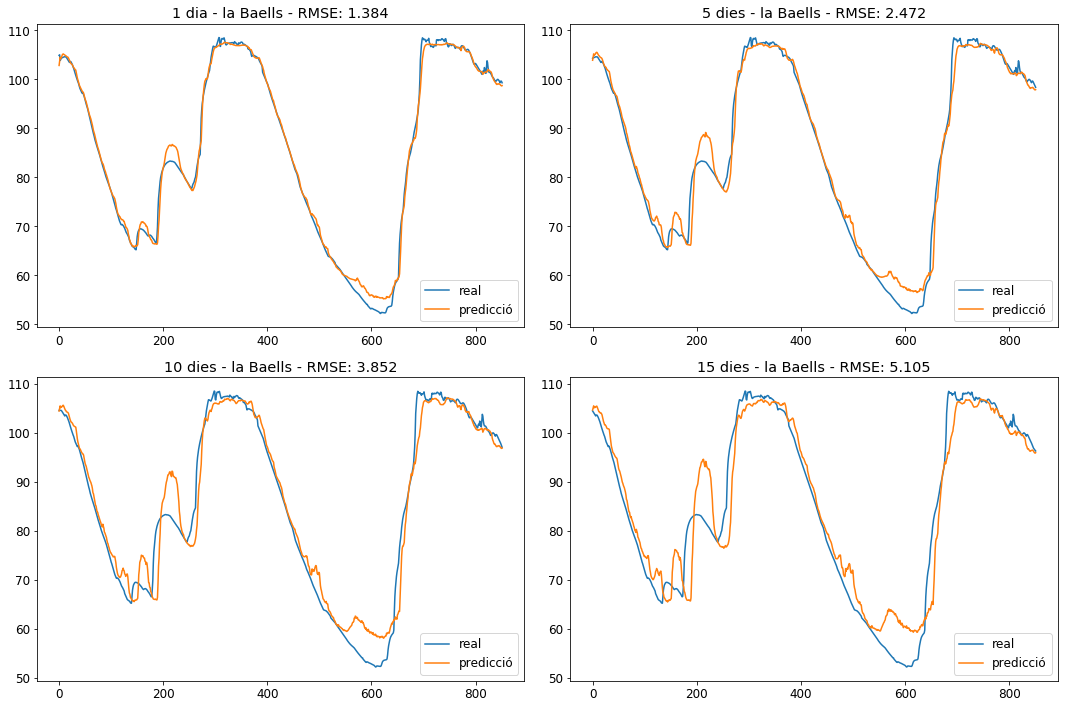

In [22]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [23]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│ 1.38388 │ 1.65075 │ 1.92055 │ 2.19672 │ 2.47182 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 2.74736 │ 3.02629 │ 3.30517 │ 3.58204 │  3.85231 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  4.11473 │  4.37142 │  4.62397 │  4.86533 │  5.10458 │ 3.48057 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [10]:
# Simulació GridSearchCV random forest
import numpy as np
resultatsf = []
arbres = np.arange(275,305,1)
# Fixem aquest valor ja que el bucle a partir d'ell repeteix els resultats.
profunditat = [84]
max_features = np.arange(16,21,1)

for arbre in arbres:
    for profund in profunditat:
        resultat = []
        for max_f in max_features:
            regr_rf = RandomForestRegressor(n_estimators=arbre, max_depth=profund, max_features=max_f, 
                                    min_samples_split = 29, min_samples_leaf=3, random_state=2)
            regr_rf.fit(train_X, train_Y)
            # Predict on new data
            yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
            # invertim prediccions per tenir-les en l'escala original
            yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
            test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
            #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            inv_yhat = scaler.inverse_transform(dataset2)
            testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
            #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
            test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

            RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
            print(RMSE_TOT,arbre, profund, max_f)
            resultat.append((arbre, profund, max_f, RMSE_days,RMSE_TOT))

        resultatsf.append(resultat)


3.589008025171821 275 84 16
3.483265220721966 275 84 17
3.549459520712312 275 84 18
3.4611839657719354 275 84 19
3.4683524327193496 275 84 20
3.5878853133748523 276 84 16
3.481307950691462 276 84 17
3.54796755032142 276 84 18
3.4627076630101112 276 84 19
3.4702659735043953 276 84 20
3.5868355153930778 277 84 16
3.4826570910624612 277 84 17
3.548225208899963 277 84 18
3.459098471488646 277 84 19
3.4710781475164647 277 84 20
3.5880578084646415 278 84 16
3.4833245623654534 278 84 17
3.5509899580921327 278 84 18
3.4590652255163814 278 84 19
3.4713437703638035 278 84 20
3.5891339095717254 279 84 16
3.4843296519869065 279 84 17
3.5497315461974135 279 84 18
3.4601235689550385 279 84 19
3.4734407981120086 279 84 20
3.5850756949862665 280 84 16
3.4812784200099056 280 84 17
3.553865064786359 280 84 18
3.4613777898840157 280 84 19
3.477067446522129 280 84 20
3.5808980301568942 281 84 16
3.4786934283401756 281 84 17
3.552420589339602 281 84 18
3.464882032473887 281 84 19
3.4796117092213406 281 84 

In [11]:
varlist = []
for i in range(len(arbres)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)

resultFinal.columns=['n_estimators','max_depth',  'max_feautres','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,n_estimators,max_depth,max_feautres,RMSE_dies,RMSE_total
0,303,84,20,"[1.3215311855936545, 1.5959352221326786, 1.876...",3.449942
1,304,84,20,"[1.3222540104032832, 1.596525184523229, 1.8773...",3.450475
2,301,84,20,"[1.3236187971983944, 1.5979217007744444, 1.878...",3.452448
3,302,84,20,"[1.3242408674174773, 1.5987545628456281, 1.879...",3.453038
4,300,84,20,"[1.3252629391680364, 1.5994758153439432, 1.879...",3.453120
5,299,84,20,"[1.327817024664324, 1.6022738576128972, 1.8829...",3.454941
6,298,84,20,"[1.325863594305898, 1.6005870827213717, 1.8814...",3.454944
7,297,84,20,"[1.326784807396368, 1.6017243611389524, 1.8827...",3.456529
8,296,84,20,"[1.325931890591721, 1.6010897435643408, 1.8824...",3.457631
9,278,84,19,"[1.3577518900553864, 1.6248061282207396, 1.902...",3.459065


In [12]:
regr_rf = RandomForestRegressor(n_estimators=303, max_depth=84, max_features=20, 
                                    min_samples_split = 29, min_samples_leaf=3, random_state=2)
            
regr_rf.fit(train_X, train_Y)
# Predict on new data
yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

3.449941843087151


In [15]:
import numpy as np
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))


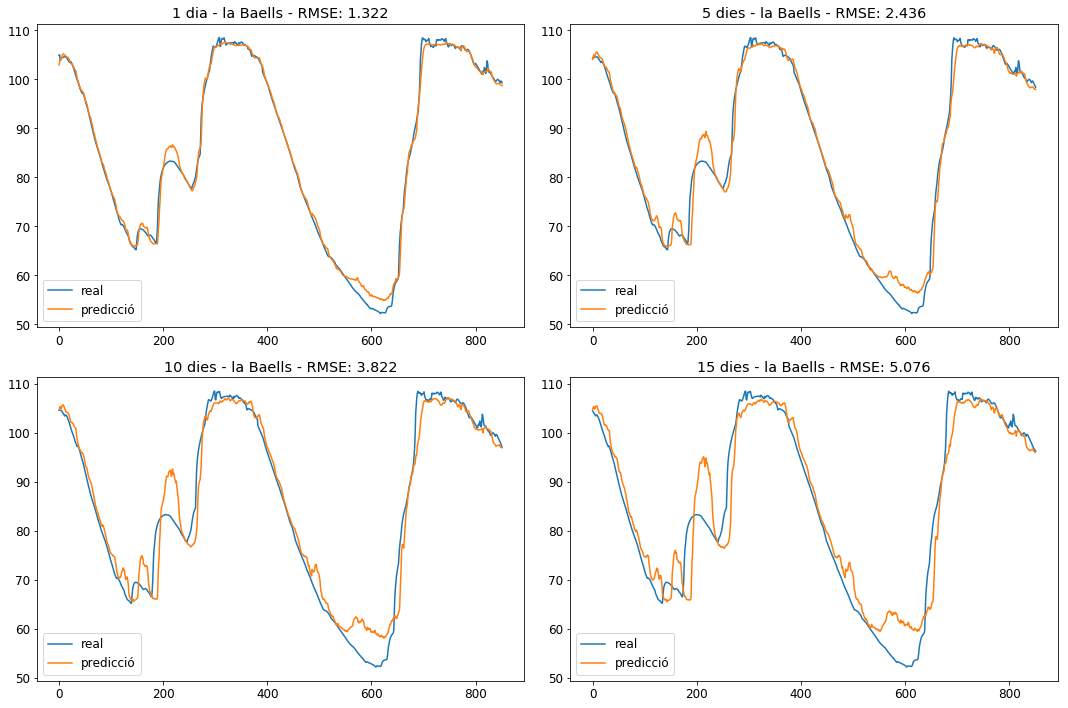

In [16]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [17]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│ 1.32153 │ 1.59594 │ 1.87684 │   2.158 │ 2.43601 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 2.71356 │ 2.99413 │ 3.27469 │ 3.55206 │   3.8219 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  4.08524 │  4.34315 │  4.59485 │  4.83927 │  5.07595 │ 3.44994 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [19]:
import numpy as np
n_steps_in = np.arange(1,31,1)
n_steps_out = 15
propTrainTest = 0.8
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    if n_input <= 20:
        max_f=n_input
    else:
        max_f=20
        
    regr_rf = RandomForestRegressor(n_estimators=303, max_depth=84, max_features=max_f, 
                                    min_samples_split = 29, min_samples_leaf=3, random_state=2)
    regr_rf.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

3.9392126860716323 1
3.9604543336006834 2
3.717572065306735 3
3.5771359031568943 4
3.583914766842893 5
3.549155931542866 6
3.5703933955309077 7
3.4375627400132327 8
3.4662396959381767 9
3.3995905437859806 10
3.3500070055863183 11
3.46999154684923 12
3.4027402430005043 13
3.4343415791810212 14
3.3901233034400677 15
3.4270573927617574 16
3.4049169145480955 17
3.4266277571678336 18
3.423640554835261 19
3.449941843087151 20
3.4998050781389205 21
3.530314977430567 22
3.512281635367721 23
3.4857030119928156 24
3.551751533357677 25
3.4873537029190627 26
3.5510633737868935 27
3.585641518867343 28
3.4874555569498837 29
3.540149084284524 30


In [20]:
resultFinal = pd.DataFrame(resultat)
    
resultFinal.columns=['time steps in', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

display(resultFinal)

,time steps in,RMSE_total
0,11,3.350007
1,15,3.390123
2,10,3.399591
3,13,3.402740
4,17,3.404917
5,19,3.423641
6,18,3.426628
7,16,3.427057
8,14,3.434342
9,8,3.437563


In [9]:
n_steps_in = 11
n_steps_out = 15
propTrainTest = 0.8

train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

regr_rf = RandomForestRegressor(n_estimators=303, max_depth=84, max_features=20, 
                                    min_samples_split = 29, min_samples_leaf=3, random_state=2)
            
regr_rf.fit(train_X, train_Y)
# Predict on new data
yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

3.3500070055863183


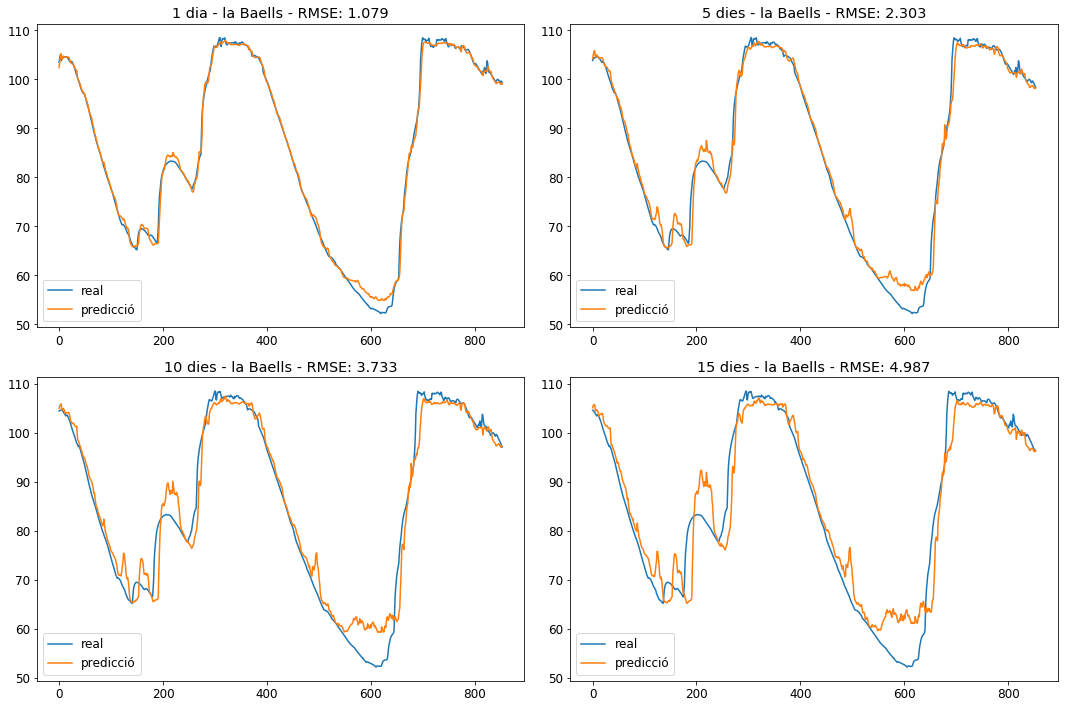

In [10]:
import numpy as np
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline

plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [12]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.0792,1.3765,1.6865,2.0000,2.3031,2.6018,2.8974,3.1872,3.4645,3.7334,3.9956,4.2551,4.5100,4.7526,4.9869,3.3500
R2,0.9965,0.9943,0.9915,0.9880,0.9841,0.9797,0.9748,0.9694,0.9639,0.9580,0.9519,0.9454,0.9386,0.9317,0.9248,0.9662
MAE,0.7148,0.8951,1.0888,1.2951,1.5025,1.7135,1.9314,2.1470,2.3552,2.5644,2.7681,2.9727,3.1745,3.3708,3.5642,2.1372
MSE,1.1647,1.8947,2.8442,4.0002,5.3043,6.7693,8.3951,10.1584,12.0027,13.9383,15.9648,18.1058,20.3397,22.5868,24.8692,11.2225


In [13]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.079,1.376,1.686,2.0,2.303,2.602,2.897,3.187,3.464,3.733,3.996,4.255,4.51,4.753,4.987,3.35


In [16]:
resultsDF.to_csv('rf-multi-baells.csv', sep=',', encoding='utf-8')